In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Data had to be cleaned slightly prior to use. The file was a series of json objects. To make the data one comprehensible json object, this command was run:

`./data/clean_data.sh data/taxi-2009-2016-monthly-summary.json`

And then a [ was placed at the start of the file and ] was placed at the end. The last comma was removed for validation (}, was changed to }).

In [2]:
trips = pd.read_json('data/taxi-2009-2016-monthly-summary.json')
trips.head()

,cnt,cohort,mean_time,percentiles,stddev_pop,stddev_samp
0,15749228,2013-03,719.445285,"[240.0, 310.0, 420.0, 480.0, 600.0, 712.0, 840...",1304.068416,1304.068458
1,15100468,2013-04,747.583700,"[240.0, 327.0, 420.0, 508.0, 600.0, 720.0, 875...",804.104881,804.104908
2,15285049,2013-05,783.730923,"[240.0, 343.0, 420.0, 540.0, 631.0, 758.0, 900...",2270.820836,2270.820911
3,14385456,2013-06,782.014114,"[240.0, 346.0, 420.0, 540.0, 636.0, 763.0, 900...",4132.919623,4132.919767
4,1541557,2016-12,947.889267,"[226.0, 323.0, 415.0, 514.0, 625.0, 756.0, 923...",3625.984479,3625.985655


In [14]:
cleaned = trips.dropna(subset=['mean_time'])

## Visualization



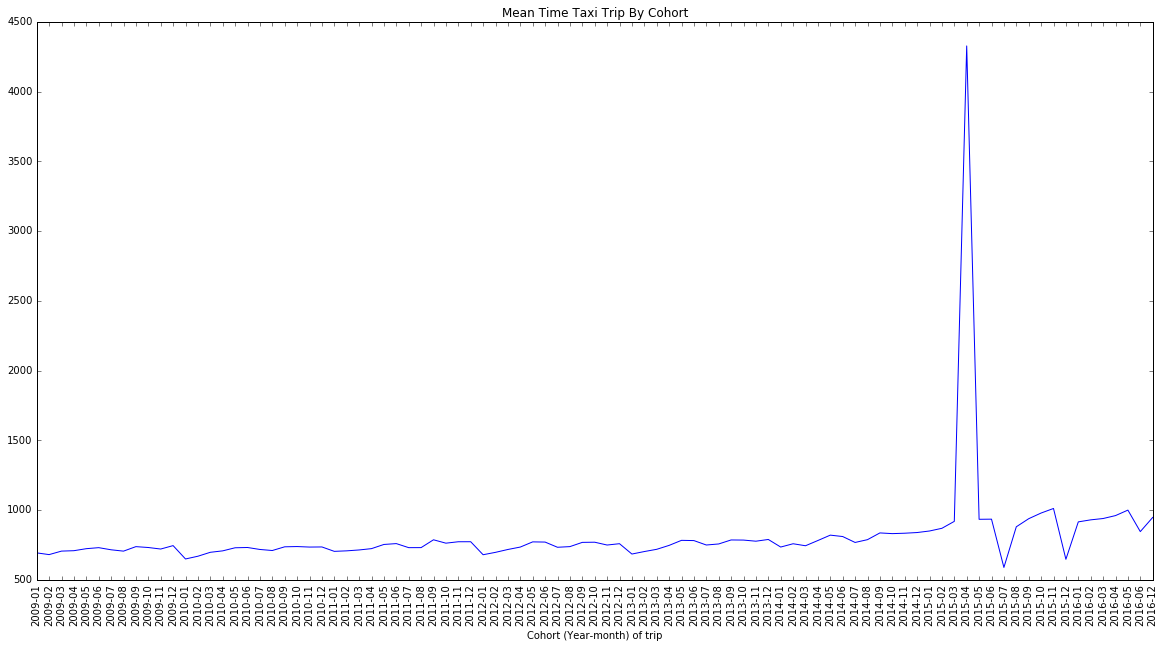

In [12]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ordered_data = cleaned.sort_values(['cohort'])
x_pos = np.arange(len(ordered_data['cohort']))
plt.plot(x_pos, ordered_data['mean_time'])
plt.xticks(x_pos, ordered_data['cohort'], rotation='vertical')
plt.xlabel('Cohort (Year-month) of trip')
plt.title('Mean Time Taxi Trip By Cohort')

plt.show()

These values should be excluded and further analyzed in the source based on the grah. Also, 2016-12 hasn't happened yet as of the time of this analysis

- 2015-04
- 2015-07
- 2015-12

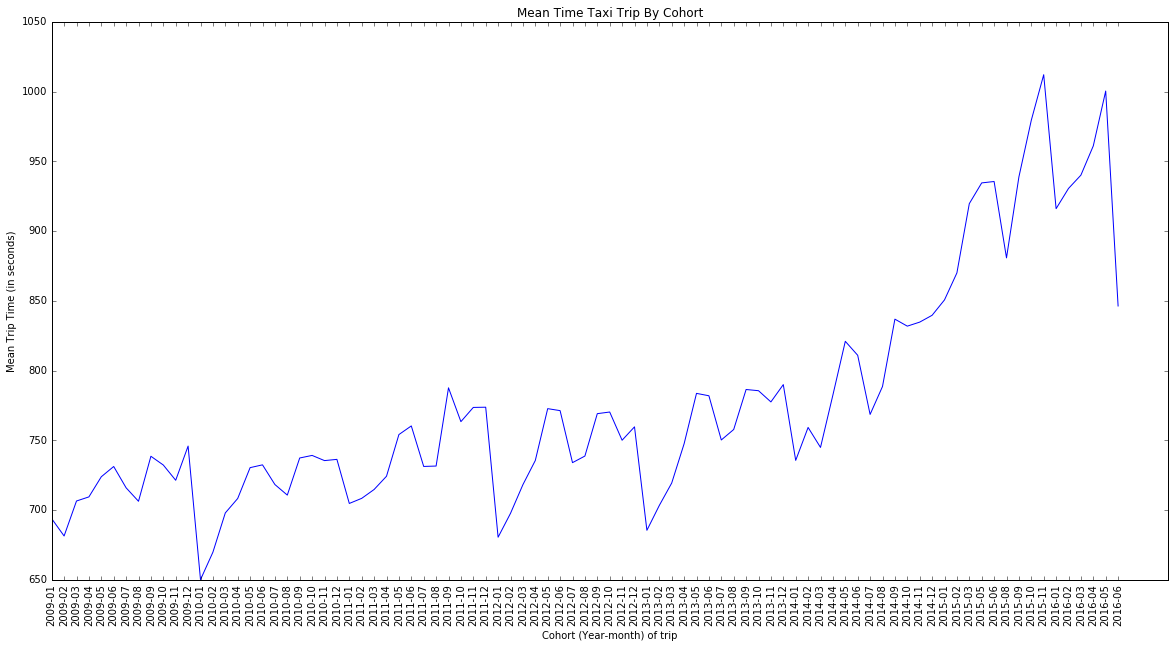

In [29]:
extreme_removed = cleaned.mask(cleaned["cohort"].isin(["2015-04", "2015-07", "2015-12", "2016-12"])).dropna(subset=['mean_time'])

ordered_data = extreme_removed.sort_values(['cohort'])
x_pos = np.arange(len(ordered_data['cohort']))
plt.plot(x_pos, ordered_data['mean_time'])
plt.xticks(x_pos, ordered_data['cohort'], rotation='vertical')
plt.xlabel('Cohort (Year-month) of trip')
plt.ylabel("Mean Trip Time (in seconds)")
plt.title('Mean Time Taxi Trip By Cohort')

plt.show()

There is a clear trend upward over time. Also, it appears that January is the best time to find a quick cab ride

## Validation

Let's do some stats. The null hypothesis is that there has been no change in the mean taxi time over a period of time. According to <my-stats-book> the way to calculate this is

$$Z = (point estimate - null value) / SE$$

$$Z = ((\mu_1-\mu_2)-0)/SE$$

Where point estimate are the empiricle mean values summarized above. SE is calculated in the following way:

$$SE_(x_1 - x_2) = \sqrt{(\sigma_{x_1}^2/n_1)+\sigma_{x_2}^2/n_2)}$$

In [62]:
# start with May 2009 to May 2016
may_09 = cleaned[cleaned["cohort"] == '2009-05']
may_16 = cleaned[cleaned["cohort"] == '2016-05']

# calc stderr
may_09_se = (may_09["stddev_pop"]**2/may_09["cnt"]).values[0] # b/c it's a Series
may_16_se = (may_16["stddev_pop"]**2/ may_16["cnt"]).values[0]
mean_se = np.sqrt(may_09_se + may_16_se)

mean_time_diff = may_16["mean_time"].values[0] - may_09["mean_time"].values[0]

z = (mean_time_diff - 0) / mean_se
z

133.69867708528039

## Confidence Interval

A 95% confidence interval can be expressed by taking the point estimate +/- z*SE where 1.96 approximates z

$$ (\mu_1 - \mu_2) \pm (1.96*SE) $$

In [66]:
# confidence
conf_err = 1.96 * mean_se
conf_95 = (mean_time_diff + conf_err, mean_time_diff - conf_err)
conf_95

(280.54853053757432, 272.44178599799767)

We can be 95% confident that the observed mean difference in travel time in a taxi is between 272.44 and 280.55 seconds. But how does this translate to cost?

According to [the official NYC taxi rates](http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml), the charge for sitting in traffic for 60 seconds is 50 cents.

In [71]:
upper_cost = (conf_95[0] * 0.50) / 60
lower_cost = (conf_95[1] * 0.50) / 60
(lower_cost, upper_cost)

(2.2703482166499804, 2.3379044211464528)

Based on time spent in the trip alone, it costs between $2.27 and $2.33 to take a taxi in 2016 than it did in 2009.

## Inconclusive

While this analysis provides evidence that taxi rides are taking longer, it does not purport to explain _why_ rides are taking longer. I have not, for example, examined if the distance between rides has increased.

## Areas For Further Analysis

- Distance 